#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE, we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]



##Exercise 6.1: Variational Autoencoder and the reparameterization trick
The reparameterization trick is an important component of VAE. It allows to implement the sampling phase, while keeping the network trainable via gradient ascent/descent.
Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the sample layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. In particular, from this class we are interested in overriding the call method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the new Sampling layer has in input a mean vector $z_{\mu}$ and a ``variance'' vector $z_{\sigma}$, and it has to compute a sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{\mu} + exp(z_{\sigma}) \odot \epsilon,
$$
where $\epsilon$ is sampled by a normal distribution with zero mean and identity covariance matrix. 

**To complete: complete the code defining the Sampling layer that implements the reparameterization trick**

**Hint: to generate a random value from a normal distribution keras provides the [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.**

**In addition to that, explain why in the reparameterization formula it makes sense to use $exp(z_{\sigma})$ instead of directly using $z_{\sigma}$.**


Using exp in the reparameterazition trick is for the output of encoder. The encoder has as output i not the variance but the log of the variance and therefore we have to use the exp to delete the effect of logarithm and, so, transform the variance into the original space.




In [0]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #To complete: compute and return z
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.keras.backend.exp(z_var) * epsilon

##Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW4), and then use the obtained encoding to compute $z_{\mu}$ and $z_\sigma$, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. 

In order to allow the exploration of the latent space, we will stick on a latent space of size $2$ (that is, the dimension of $z$ should be $2$).

**To complete: complete the code defining a deep encoder and the Dense layers that model $z_{\mu}$ and $z_\sigma$. Justify in this cell your choice for what concerns the layers sizes and the activation functions** 


I used three layers of encoding with 512, 256, 128 to create hourglass tips. I used the relu as an activation function because it performs better than the other functions and I believe this is possible because for values ​​less than 0 it returns 0 and for values ​​greater than 0 it behaves like a linear function.

In [340]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(512, activation = 'relu')(encoder_inputs)
x1 = tf.keras.layers.Dense(256, activation = 'relu')(x)
x2 = tf.keras.layers.Dense(128, activation = 'relu')(x1)
#...To complete...
z_mean =  tf.keras.layers.Dense(latent_dim)(x2)
z_var =  tf.keras.layers.Dense(latent_dim)(x2)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_234 (Dense)               (None, 512)          401920      input_73[0][0]                   
__________________________________________________________________________________________________
dense_235 (Dense)               (None, 256)          131328      dense_234[0][0]                  
__________________________________________________________________________________________________
dense_236 (Dense)               (None, 128)          32896       dense_235[0][0]                  
____________________________________________________________________________________________

##Exercise 6.3: Decoder
Then we have to define the decoder part. It has in input $z$ and returns its "decoding". Its topology will have a ``mirror'' shape w.r.t. the encoder. 

**To complete: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes and the activation functions (in particular for what concerns the last layer)**


I used two layers of decoder with 512, 256, 128 to be consistent with the encoder. I used the relu as an activation function because it performs better than the other functions and for the output level I used the sigmoid because the output is an image and performs better.

In [341]:
latent_inputs = keras.Input(shape=(latent_dim,))
x2 = tf.keras.layers.Dense(128, activation = 'relu')(latent_inputs)
x1 = tf.keras.layers.Dense(256, activation = 'relu')(x2)
x = tf.keras.layers.Dense(512, activation = 'relu')(x1)
#...To complete...
decoder_outputs = tf.keras.layers.Dense(784, activation = 'sigmoid' )(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_239 (Dense)            (None, 128)               384       
_________________________________________________________________
dense_240 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_241 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_242 (Dense)            (None, 784)               402192    
Total params: 567,184
Trainable params: 567,184
Non-trainable params: 0
_________________________________________________________________


##Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad hoc training phase. In particular, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the original inputs, and a regularization loss that helps to learn well-formed latent spaces (Gaussian prior) and reduces overfitting to the training data. The regularization loss involves the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**To complete: implement the reconstruction loss and KL-loss (look at the VAE paper in Moodle)**

I follow the VAE paper.
I multiplied reconstruction_loss by original dimension of training set (784) because I do the average loss for each pixel, which I have to multiply by 784 to get an estimate of the loss of the whole image.


In [0]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(data,reconstruction))
            reconstruction_loss *= x_train.shape[1]
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_var - tf.square(z_mean)-tf.math.exp(z_var)))
        
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer

In [343]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=50, batch_size=128)

Epoch 1/50
391/391 [==============================] - 9s 23ms/step - loss: 24320.0048 - reconstruction_loss: 23927.6192 - kl_loss: 392.3856
Epoch 2/50
391/391 [==============================] - 9s 23ms/step - loss: 20413.0750 - reconstruction_loss: 20030.4208 - kl_loss: 382.6542
Epoch 3/50
391/391 [==============================] - 9s 23ms/step - loss: 19765.0095 - reconstruction_loss: 19369.9640 - kl_loss: 395.0455
Epoch 4/50
391/391 [==============================] - 9s 22ms/step - loss: 19413.3352 - reconstruction_loss: 19000.1514 - kl_loss: 413.1838
Epoch 5/50
391/391 [==============================] - 9s 23ms/step - loss: 19092.1762 - reconstruction_loss: 18663.4077 - kl_loss: 428.7685
Epoch 6/50
391/391 [==============================] - 9s 22ms/step - loss: 18750.0335 - reconstruction_loss: 18315.5344 - kl_loss: 434.4991
Epoch 7/50
391/391 [==============================] - 9s 23ms/step - loss: 18521.6494 - reconstruction_loss: 18084.5687 - kl_loss: 437.0806
Epoch 8/50
391/391 [

##Exercise 6.5: Model Analysis
We can now plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate several  2D $\hat{z}$ samples and pass them to our decoder. The interval where to sample  $\hat{z}$ can be controlled by the $scale$ parameter, while the number of generated samples is controlled by the $n$ parameter.


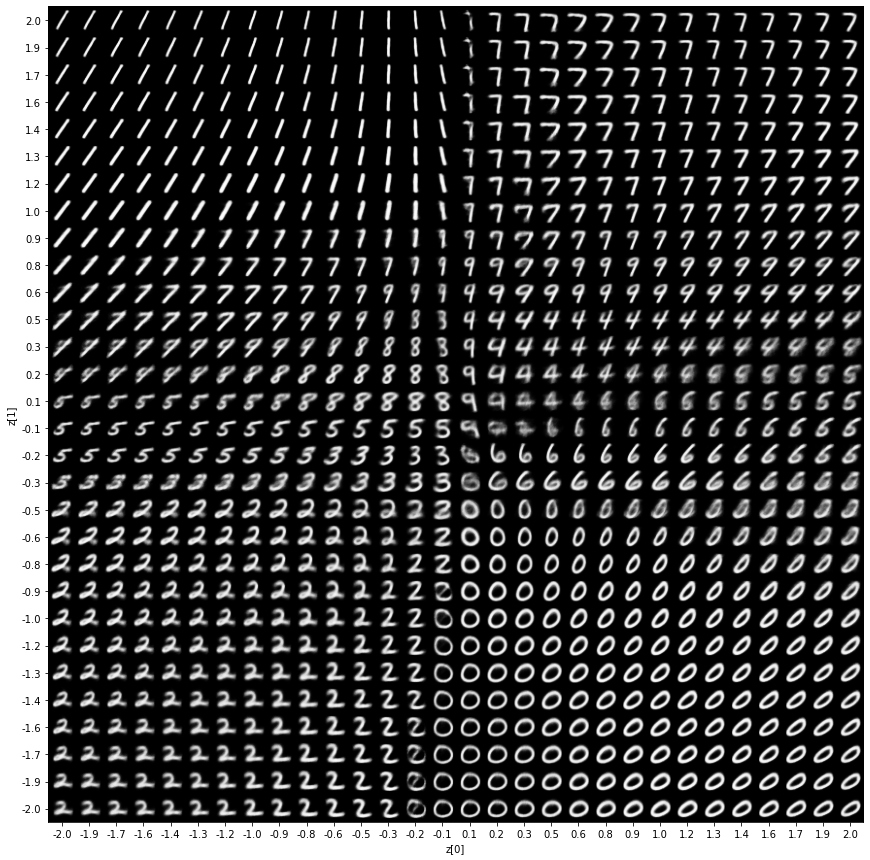

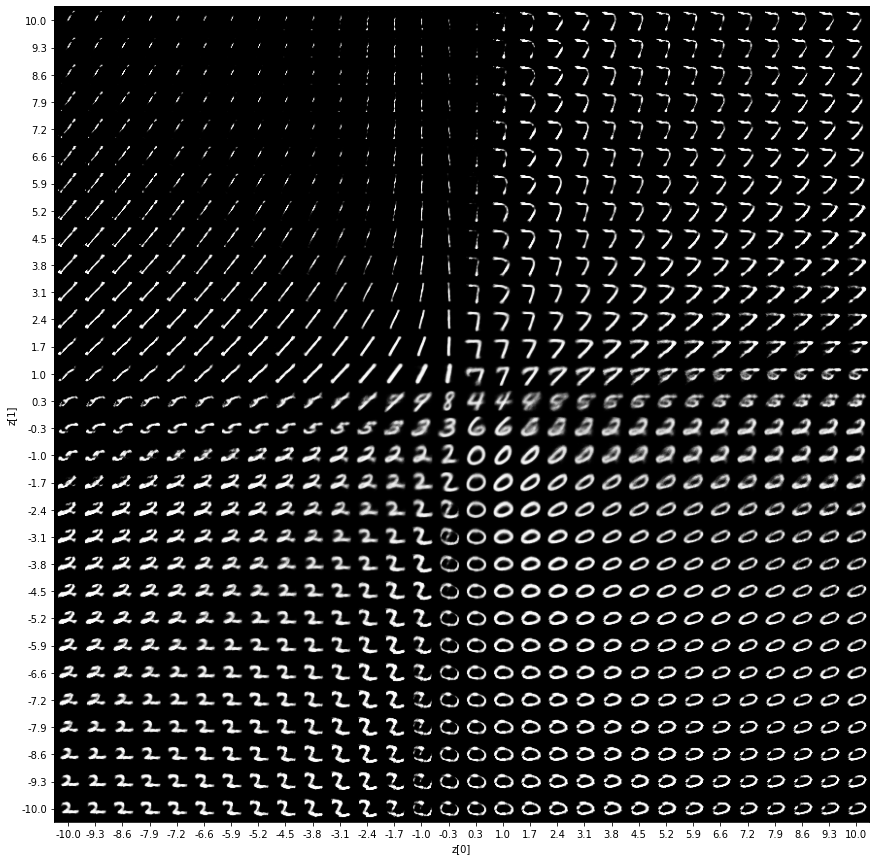

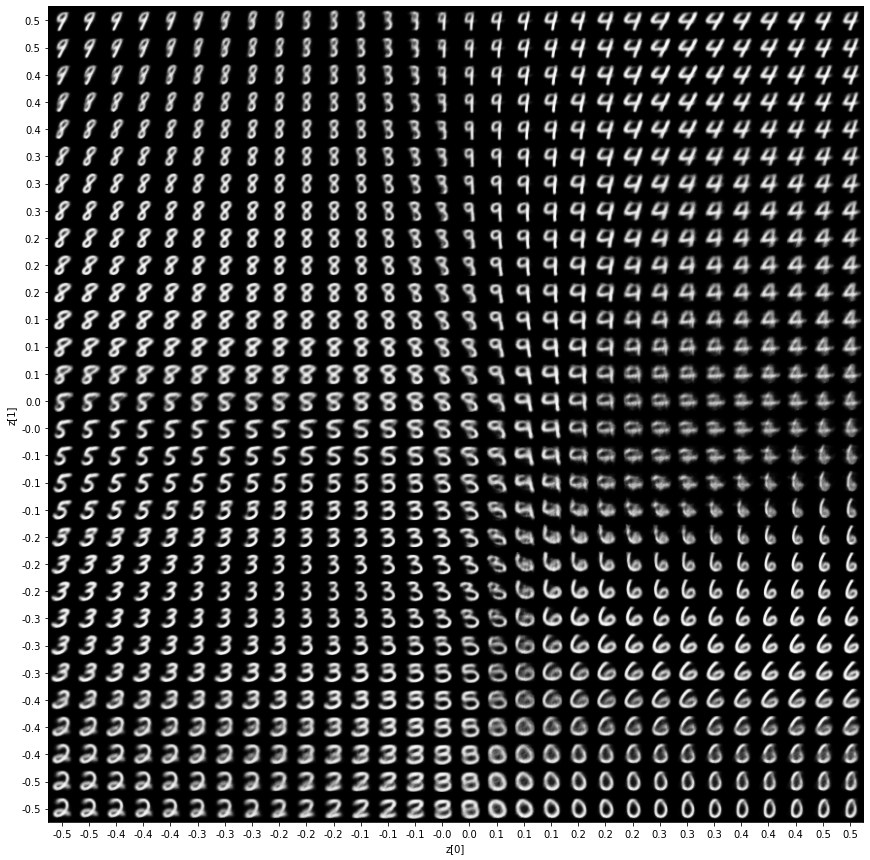

In [344]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()



plot_latent(encoder, decoder, 2.0, 30) 
plot_latent(encoder, decoder, 10.0, 30) 
plot_latent(encoder, decoder, 0.5, 30) 
#To complete: explore with different "scale"

Let's finaly check how the different digits have been rapresented in the latent space by the VAE.

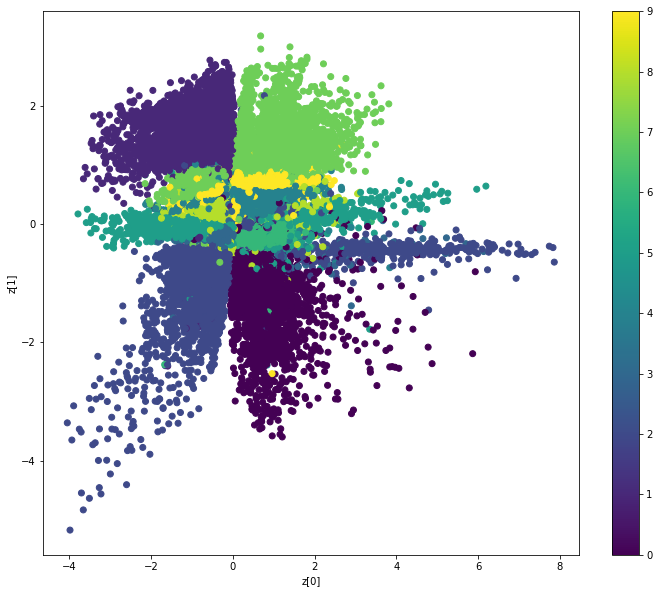

In [345]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**To complete: Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result.**

In the second plot clusters don't seem to be perfectly divided. The data manifolds for 2-d z with scale 0.5 and 2.0 don't seem very bad.
The data manifold for 2-d z with scale 10 semms bad.
When I built my VAE I try to use many activation function (sigmoid, tanh, relu and many combinations of them) but I obtained better results with using only relu. I try to midify the number of layer less then the actual and I have not noticed big differences. I also increased the number of epoch and I have not noticed big differences too.
